In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import KFold,validation_curve,cross_val_score
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.svm import SVC
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")

## 1. Data Understanding
+ Data information
+ Draw time series graphs with trend and seasonality
+ Using groupby method to find some insights

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
display(df_train)
display(df_test)

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17


,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB
...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB
2336,851171,1991-09-30 23:40:00,2,3,NE
2337,851172,1991-09-30 23:40:00,2,3,SB
2338,851173,1991-09-30 23:40:00,2,3,SW


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   row_id      848835 non-null  int64 
 1   time        848835 non-null  object
 2   x           848835 non-null  int64 
 3   y           848835 non-null  int64 
 4   direction   848835 non-null  object
 5   congestion  848835 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 38.9+ MB


In [4]:
df_train['time'] = pd.to_datetime(df_train['time'])
df_train_EB = df_train[(df_train['x'] == 0)&(df_train['y'] == 0)&(df_train['direction'] == 'EB')]
df_time = df_train_EB.loc[:,['time','congestion']]
df_time = df_time.set_index('time')
df_time

,congestion
time,
1991-04-01 00:00:00,70
1991-04-01 00:20:00,70
1991-04-01 00:40:00,70
1991-04-01 01:00:00,70
1991-04-01 01:20:00,70
...,...
1991-09-30 10:20:00,43
1991-09-30 10:40:00,47
1991-09-30 11:00:00,40


In [5]:
def identify_periods(data):
    # YOUR CODE HERE

    #annul plot
    a = data.copy()
    plt.figure(figsize=(14,5))
    plt.plot(a)
    plt.xticks(rotation=60)
    plt.show()
    
    #weekly plot
    b = data.copy()
    b['month'] = b.index
    b['month'] = b['month'].dt.month
    mean = b.groupby('month')['congestion'].mean()
    plt.figure(figsize=(10,5))
    plt.plot(mean)
    plt.xticks(rotation=60)
    plt.show()
    
    #daily plot
    c = data.copy()
    c['hour'] = c.index
    c['hour'] = c['hour'].dt.hour
    mean = c.groupby('hour')['congestion'].mean()
    plt.figure(figsize=(10,5))
    plt.plot(mean)
    plt.xticks(rotation=60)
    plt.show()
    

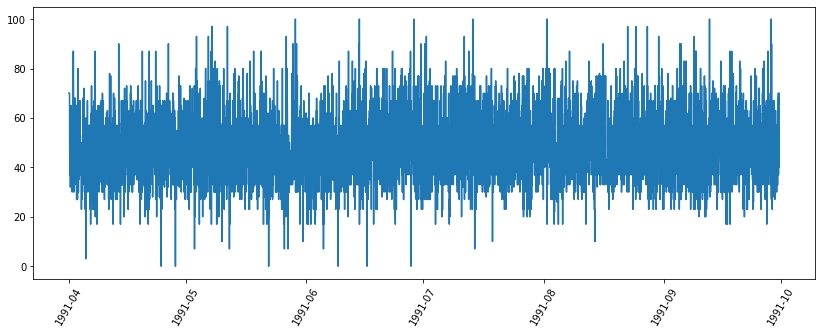

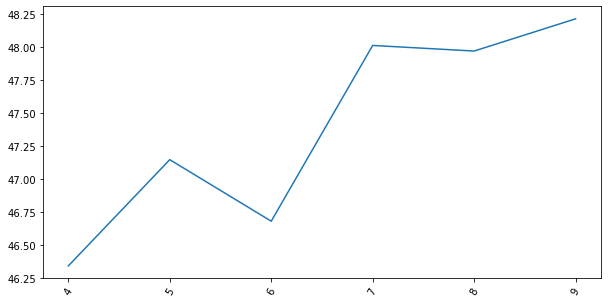

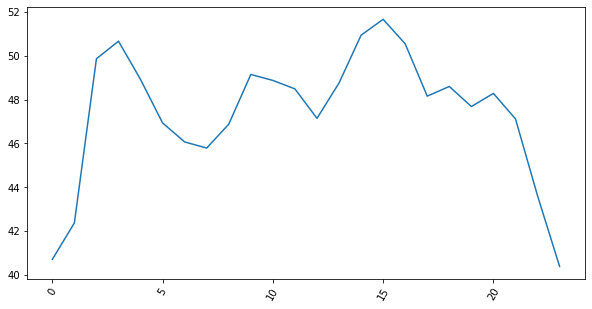

In [6]:
identify_periods(df_time)

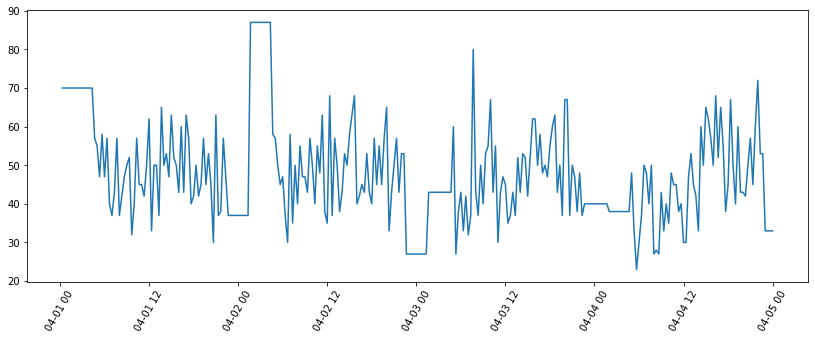

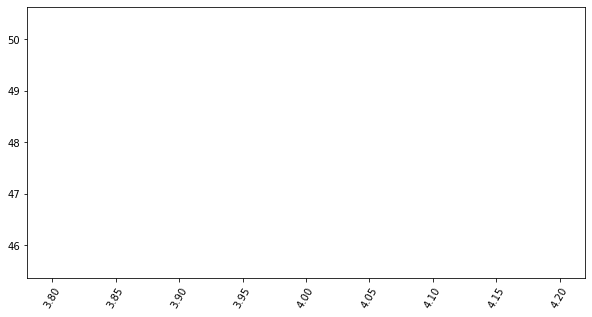

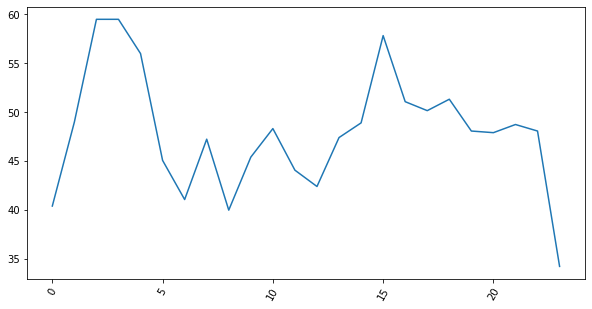

In [7]:
df_time_month = df_time[(df_time.index < '1991-04-05 00:20:00')&(df_time.index > '1991-04-01 00:00:00')]
identify_periods(df_time_month)

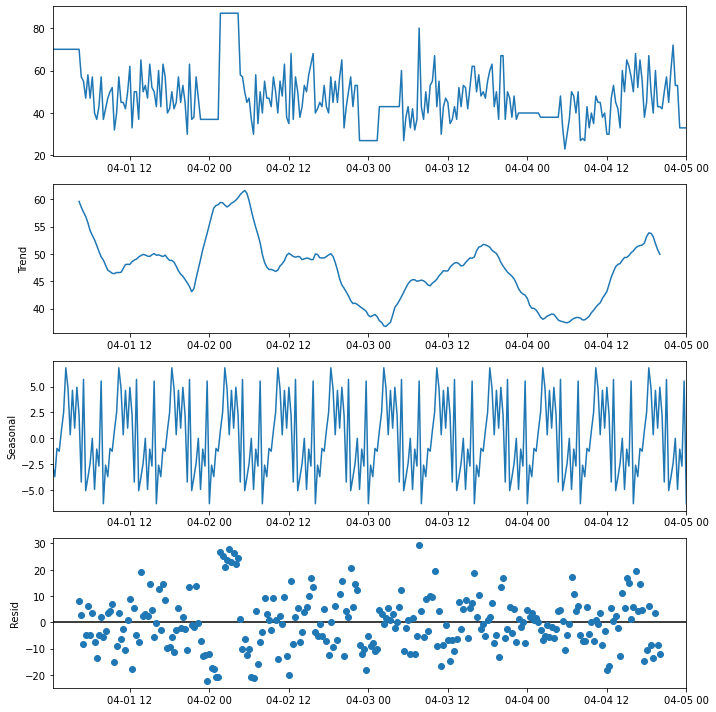

In [8]:
df_time_month = df_time[(df_time.index < '1991-04-05 00:20:00')&(df_time.index > '1991-04-01 00:00:00')]

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_time_month, model = 'additive',period=24) # Period =7 because seasonality is on weekly basis
plt.rcParams['figure.figsize'] = [10,10]
decomposition.plot()
plt.show()

### Groupby method

In [9]:
df_train_str = df_train.copy()
df_train_str['x'] = df_train['x'].astype(str)
df_train_str['y'] = df_train['y'].astype(str)
df_train_str['direction'] = df_train['direction'].astype(str)
df_train_str['combined'] = df_train_str['x'].str.cat(df_train_str['y']).str.cat(df_train_str['direction'])
#df_train['combined']=df_train.apply(lambda x:'%s_%s_%s' % (df_train['x'],df_train['y'],df_train['direction']),axis=1)
df_train_str

,row_id,time,x,y,direction,congestion,combined
0,0,1991-04-01 00:00:00,0,0,EB,70,00EB
1,1,1991-04-01 00:00:00,0,0,NB,49,00NB
2,2,1991-04-01 00:00:00,0,0,SB,24,00SB
3,3,1991-04-01 00:00:00,0,1,EB,18,01EB
4,4,1991-04-01 00:00:00,0,1,NB,60,01NB
...,...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54,23NB
848831,848831,1991-09-30 11:40:00,2,3,NE,28,23NE
848832,848832,1991-09-30 11:40:00,2,3,SB,68,23SB
848833,848833,1991-09-30 11:40:00,2,3,SW,17,23SW


In [10]:
df_train_str1 = df_train.copy()
df_train_str1['x'] = df_train_str1['x'].astype(str)
df_train_str1['y'] = df_train_str1['y'].astype(str)
df_train_str1['direction'] = df_train_str1['direction'].astype(str)
df_train_str1['combined_xy'] = df_train_str1['x'].str.cat(df_train_str1['y'],sep=',')
df_train_str1['combined_all'] = df_train_str1['x'].str.cat(df_train_str1['y'],sep=',').str.cat(df_train_str['direction'],sep='_')
df_train_str1 = df_train_str1.loc[:,['combined_all','direction','congestion','time']]
a = df_train_str1.groupby('combined_all').mean()
a
#a = df_train_str1.loc[:,['combined','direction','congestion']]
#a

,congestion
combined_all,
"0,0_EB",47.396202
"0,0_NB",39.513286
"0,0_SB",49.864155
"0,1_EB",26.942492
"0,1_NB",68.888429
...,...
"2,3_NB",58.609771
"2,3_NE",32.074585
"2,3_SB",70.617735


In [11]:
a = a.reset_index()
a[['coordinate','direction']]=a['combined_all'].str.split('_',expand=True)
a[['x','y']]=a['coordinate'].str.split(',',expand=True)
a = a.drop(['combined_all'],axis=1)
a

,congestion,coordinate,direction,x,y
0,47.396202,"0,0",EB,0,0
1,39.513286,"0,0",NB,0,0
2,49.864155,"0,0",SB,0,0
3,26.942492,"0,1",EB,0,1
4,68.888429,"0,1",NB,0,1
...,...,...,...,...,...
60,58.609771,"2,3",NB,2,3
61,32.074585,"2,3",NE,2,3
62,70.617735,"2,3",SB,2,3
63,19.522322,"2,3",SW,2,3


In [12]:
a.to_csv('histogram_rawdata.csv',index=False)

## 2. Data preparation
+ Add new features
+ Set X_train and X_test
+ Encode X_train and X_test (Onehot encoding)

In [29]:
df_train['month'] = df_train['time']
df_train['month'] = df_train['month'].dt.month
df_train['day'] = df_train['time']
df_train['day'] = df_train['day'].dt.day
df_train['weekday'] = df_train['time']
df_train['weekday'] = (df_train['weekday'].dt.weekday)+1
df_train['hour'] = df_train['time']
df_train['hour'] = df_train['hour'].dt.hour
df_train['week'] = df_train['time']
df_train['week'] = df_train['week'].dt.week
df_train['whether_weekdays']=df_train['weekday'].apply(lambda x:1 if x<6 else 0)

df_test['time'] = pd.to_datetime(df_test['time'])
df_test['month'] = df_test['time']
df_test['month'] = df_test['month'].dt.month
df_test['day'] = df_test['time']
df_test['day'] = df_test['day'].dt.day
df_test['weekday'] = df_test['time']
df_test['weekday'] = (df_test['weekday'].dt.weekday)+1
df_test['hour'] = df_test['time']
df_test['hour'] = df_test['hour'].dt.hour
df_test['week'] = df_test['time']
df_test['week'] = df_test['week'].dt.week
df_test['whether_weekdays']=df_test['weekday'].apply(lambda x:1 if x<6 else 0)

In [30]:
df_train

,row_id,time,x,y,direction,congestion,month,day,weekday,hour,week,whether_weekdays
0,0,1991-04-01 00:00:00,0,0,EB,70,4,1,1,0,14,1
1,1,1991-04-01 00:00:00,0,0,NB,49,4,1,1,0,14,1
2,2,1991-04-01 00:00:00,0,0,SB,24,4,1,1,0,14,1
3,3,1991-04-01 00:00:00,0,1,EB,18,4,1,1,0,14,1
4,4,1991-04-01 00:00:00,0,1,NB,60,4,1,1,0,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54,9,30,1,11,40,1
848831,848831,1991-09-30 11:40:00,2,3,NE,28,9,30,1,11,40,1
848832,848832,1991-09-30 11:40:00,2,3,SB,68,9,30,1,11,40,1
848833,848833,1991-09-30 11:40:00,2,3,SW,17,9,30,1,11,40,1


In [39]:
#Data
#X_train = df_train[(df_train['weekday'] ==1 )&(df_train['hour'] >= 12)&(df_train['hour'] < 23)]
X_train = df_train.drop(['congestion','time','week','month'],axis=1)
X_train = X_train.set_index('row_id')
#y_train = df_train[(df_train['weekday'] ==1 )&(df_train['hour'] >= 12)&(df_train['hour'] < 23)]
y_train = df_train['congestion']

X_test = df_test.copy()
X_test = X_test.set_index('row_id')
X_test = X_test.drop(['time','week','month'],axis=1)

#Encode
'''enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ord_cols = ['direction']
X_train[ord_cols] = enc.fit_transform(X_train[ord_cols])
X_test[ord_cols] = enc.transform(X_test[ord_cols])
'''
onehot_cols = ['direction','x','y']
onehot_enc = OneHotEncoder(handle_unknown='ignore')
onehot_enc.fit(X_train[onehot_cols])
colnames = list(onehot_enc.get_feature_names(input_features=onehot_cols))
onehot_vals = onehot_enc.transform(X_train[onehot_cols]).toarray()
enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X_train.index)
X_train = pd.concat([X_train,enc_df],axis=1).drop(onehot_cols,axis=1)

colnames = list(onehot_enc.get_feature_names(input_features=onehot_cols))
onehot_vals = onehot_enc.transform(X_test[onehot_cols]).toarray()
enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X_test.index)
X_test = pd.concat([X_test,enc_df],axis=1).drop(onehot_cols,axis=1)

In [40]:
X_train

,day,weekday,hour,whether_weekdays,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB,x_0,x_1,x_2,y_0,y_1,y_2,y_3
row_id,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,30,1,11,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
848831,30,1,11,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
848832,30,1,11,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


<AxesSubplot:>

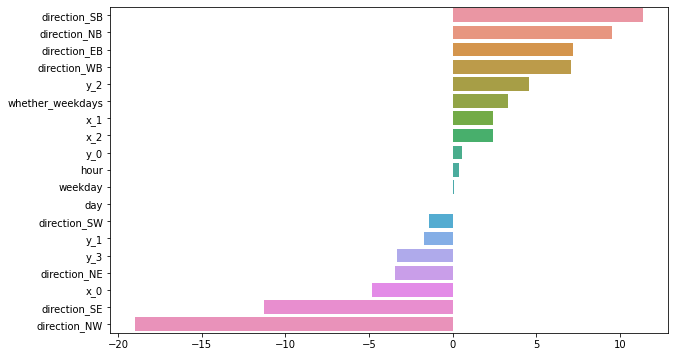

In [17]:
#coefficient
#model = LinearRegression()
model = Ridge()
model.fit(X_train, y_train)
preds = model.predict(X_test)
plt.figure(figsize=(10, 6))
coef = pd.Series(model.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [41]:
#model = LinearRegression()
#model = Ridge()
#model.fit(X_train, y_train)
#preds = model.predict(X_test)
#X_test['congestion'] = np.round(preds,0)
#X_test_clean = X_test.loc[:,['congestion']]

#RandomForest
model_rf = RandomForestRegressor(n_estimators=10)
model_rf.fit(X_train, y_train)
pred = model_rf.predict(X_test)
pred = np.round(pred, 0)
X_test['congestion'] = pred
X_test

,day,weekday,hour,whether_weekdays,direction_EB,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB,x_0,x_1,x_2,y_0,y_1,y_2,y_3,congestion
row_id,,,,,,,,,,,,,,,,,,,,
848835,30,1,12,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,46.0
848836,30,1,12,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,37.0
848837,30,1,12,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,53.0
848838,30,1,12,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,32.0
848839,30,1,12,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851170,30,1,23,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,68.0
851171,30,1,23,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,32.0
851172,30,1,23,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,72.0


In [42]:
X_test_clean = X_test.loc[:,['congestion']]
X_test_clean

,congestion
row_id,
848835,46.0
848836,37.0
848837,53.0
848838,32.0
848839,73.0
...,...
851170,68.0
851171,32.0
851172,72.0


In [43]:
X_test_clean.to_csv('test_prediction.csv',index=True)

## 3. Optimization
+ Feature selection
+ Algorithm selection
+ Hyperparameter selection

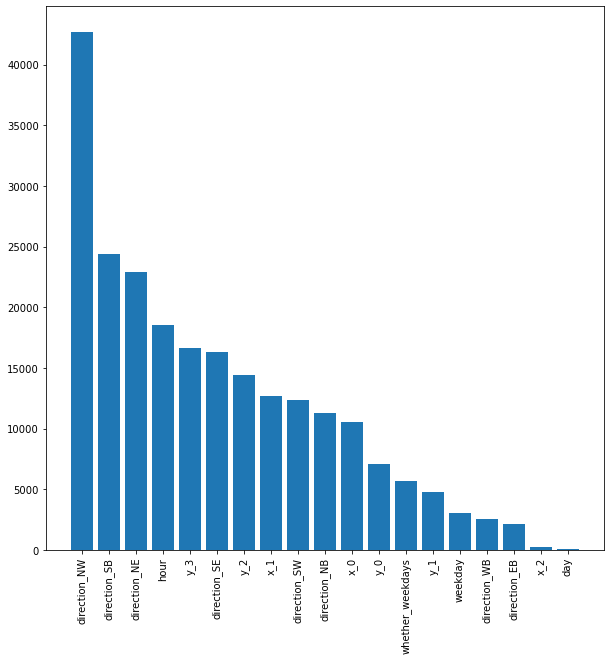

In [508]:
#Feature Selection
ftest = SelectKBest(score_func=f_regression, k='all')
ftest.fit(X_train,y_train)
f_scores = pd.DataFrame(ftest.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
f_scores = pd.concat([dfcolumns,f_scores],axis=1)
f_scores.columns = ['Feature','Score']  
f_scores = f_scores.sort_values(by='Score',ascending=False)

plt.bar(x=f_scores['Feature'],height=f_scores['Score'])
plt.xticks(rotation=90)
plt.show()

In [44]:
#validation set---model
model1 = LinearRegression()
model2 = Lasso()
model3 = Ridge()
model4 = RandomForestRegressor()
model5 = DecisionTreeRegressor()
list1 = [model1,model2,model3,model4,model5]
mse_all = []
score = pd.DataFrame()
for model in list1:
    model.fit(X_train,y_train)
    cv_scores = cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=3)
    cv_mse = np.mean(abs(cv_scores))
    mse_all.append(cv_mse)
data = []
list2 = ['Linear Regression','Lasso','Ridge','RandomForestRegressor','DecisionTreeRegressor']
data.append(list2)
data.append(mse_all)
score = pd.DataFrame(data).transpose()
score.columns=['model', 'mse_val']
score
#best_model = list1[np.argmin(mse_all)]
#best_model

,model,mse_val
0,Linear Regression,214.8812
1,Lasso,273.89019
2,Ridge,214.880535
3,RandomForestRegressor,113.111181
4,DecisionTreeRegressor,126.802319


In [501]:
#validation set---hyperparameter
list2 = np.arange(1,101,10)
mse_all = []
for i in list2:
    model_test = RandomForestRegressor(n_estimators = i)
    cv_scores = cross_val_score(model_test,X_train,y_train,scoring='neg_mean_squared_error',cv=3)
    cv_mse = np.mean(abs(cv_scores))
    mse_all.append(cv_mse)
data1 = []
data1.append(list2)
data1.append(mse_all)
score1 = pd.DataFrame(data1).transpose()
score1.columns=['n_estimators', 'mse_val']
score1
#best_alpha = list2[np.argmin(mse_all)]
#best_alpha

,n_estimators,mse_val
0,1.0,144.861879
1,11.0,115.658755
2,21.0,114.346989
3,31.0,113.772786
4,41.0,113.534205
5,51.0,113.442033
6,61.0,113.349013
7,71.0,113.285901
8,81.0,113.181034
9,91.0,113.095458


In [512]:
#validation set---hyperparameter_detail
list3 = np.arange(10,21,1)
mse_all = []
for i in list3:
    model_test = RandomForestRegressor(n_estimators = i)
    model_test.fit(X_train,y_train)
    cv_scores = cross_val_score(model_test,X_train,y_train,scoring='neg_mean_squared_error',cv=3)
    cv_mse = np.mean(abs(cv_scores))
    mse_all.append(cv_mse)
data2 = []
data2.append(list3)
data2.append(mse_all)
score2 = pd.DataFrame(data2).transpose()
score2.columns=['n_estimators', 'mse_val']
score2
#best_alpha = list3[np.argmin(mse_all)]
#best_alpha

,n_estimators,mse_val
0,10.0,116.085650
1,11.0,115.756622
2,12.0,115.401609
3,13.0,115.418085
4,14.0,115.127827
5,15.0,114.809243
6,16.0,114.831308
7,17.0,114.657821
8,18.0,114.524907
9,19.0,114.450816


In [23]:
def model_mse(X_train,X_val,y_train,y_val,model):

    model.fit(X_train,y_train)
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    train_mae = mean_squared_error(y_train,train_preds)
    val_mae = mean_squared_error(y_val,val_preds)
    return float(train_mae), float(val_mae)
    raise NotImplementedError()

In [24]:
def validation_curve(X_cv,y_cv,msl_range):
    mse_train = []
    mse_val = []
    for msl in msl_range:
        model = RandomForestRegressor(n_estimators=msl,random_state=0)
        kf = KFold(n_splits=3)
        fold_mse_train = []
        fold_mse_val = []
        for (train_idx,val_idx) in kf.split(X=X_cv,y=y_cv):
            X_fold_train, X_fold_val = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
            y_fold_train, y_fold_val = y_cv.iloc[train_idx], y_cv.iloc[val_idx]
            mse_train1, mse_val1 = model_mse(X_fold_train,X_fold_val,y_fold_train,y_fold_val,model)
            fold_mse_train.append(mse_train1)
            fold_mse_val.append(mse_val1)
        mean_mse_train = np.mean(fold_mse_train)
        mean_mse_val = np.mean(fold_mse_val)
        mse_train.append(mean_mse_train)
        mse_val.append(mean_mse_val)
    return mse_train,mse_val
    raise NotImplementedError()

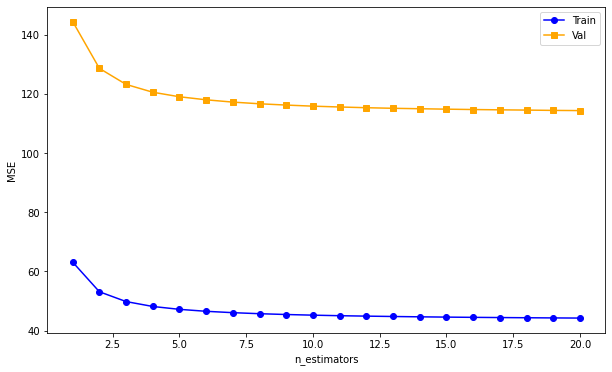

In [36]:
msl_range = np.arange(1,21,1)
train_mae_vals, val_mae_vals = validation_curve(X_train,y_train,msl_range)
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,21,1),train_mae_vals,color='blue',marker='o',label='Train')
plt.plot(np.arange(1,21,1),val_mae_vals,color='orange',marker='s',label='Val')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [37]:
def validation_curve(X_cv,y_cv,msl_range):
    mse_train = []
    mse_val = []
    for msl in msl_range:
        model = RandomForestRegressor(min_samples_leaf=msl,random_state=0)
        kf = KFold(n_splits=3)
        fold_mse_train = []
        fold_mse_val = []
        for (train_idx,val_idx) in kf.split(X=X_cv,y=y_cv):
            X_fold_train, X_fold_val = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
            y_fold_train, y_fold_val = y_cv.iloc[train_idx], y_cv.iloc[val_idx]
            mse_train1, mse_val1 = model_mse(X_fold_train,X_fold_val,y_fold_train,y_fold_val,model)
            fold_mse_train.append(mse_train1)
            fold_mse_val.append(mse_val1)
        mean_mse_train = np.mean(fold_mse_train)
        mean_mse_val = np.mean(fold_mse_val)
        mse_train.append(mean_mse_train)
        mse_val.append(mean_mse_val)
    return mse_train,mse_val
    raise NotImplementedError()

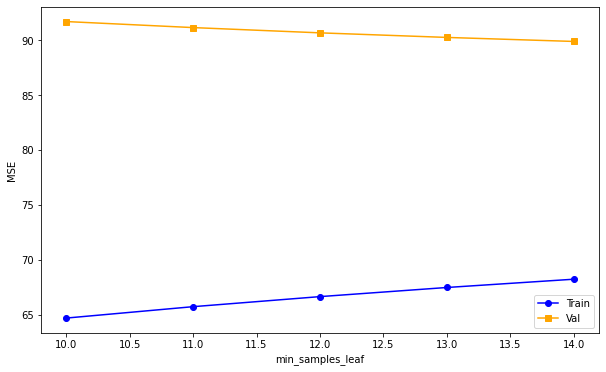

In [38]:
msl_range = np.arange(10,15,1)
train_mae_vals, val_mae_vals = validation_curve(X_train,y_train,msl_range)
plt.figure(figsize=(10,6))
plt.plot(np.arange(10,15,1),train_mae_vals,color='blue',marker='o',label='Train')
plt.plot(np.arange(10,15,1),val_mae_vals,color='orange',marker='s',label='Val')
plt.xlabel('min_samples_leaf')
plt.ylabel('MSE')
plt.legend()
plt.show()

<AxesSubplot:>

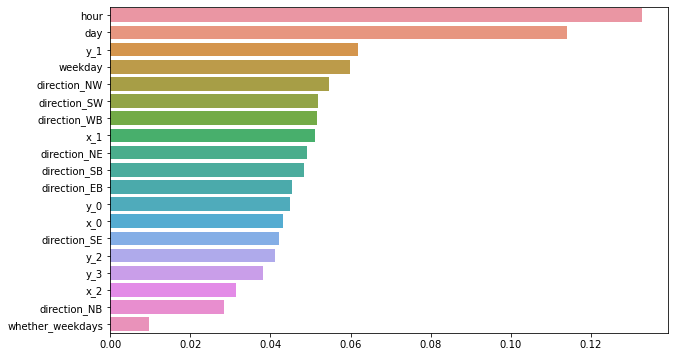

In [35]:
#model_rf.feature_importances_
plt.figure(figsize=(10, 6))
coef = pd.Series(model_rf.feature_importances_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)